In [8]:
pip install pytorch-fid

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
# Paths
real_dir = "../celebA/celeba/real_10000/img_align_celeba"
fake_dirs = {
    "VAE": "../vae_outputs/generated"
    # "VQGAN": "../vqgan_outputs/generated",
    # "WGAN": "../gan_outputs/generated"
}
label_map = {0: "Real", 1: "VAE", 2: "VQGAN", 3: "WGAN"}

In [ ]:
# Dataset
class TSNEDataset(Dataset):
    def __init__(self, real_dir, fake_dirs, transform, samples_per_class=1000):
        self.paths, self.labels = [], []

        real_imgs = sorted(os.listdir(real_dir))[:samples_per_class]
        self.paths += [os.path.join(real_dir, img) for img in real_imgs]
        self.labels += [0] * samples_per_class

        for idx, (name, fdir) in enumerate(fake_dirs.items(), start=1):
            fake_imgs = sorted(os.listdir(fdir))[:samples_per_class]
            self.paths += [os.path.join(fdir, img) for img in fake_imgs]
            self.labels += [idx] * samples_per_class

        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), self.labels[idx]

# Setup
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = TSNEDataset(real_dir, fake_dirs, transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

Extracting features: 100%|██████████| 32/32 [00:03<00:00,  8.96it/s]
/sciclone/data10/iahewababarand/.venv/lib64/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


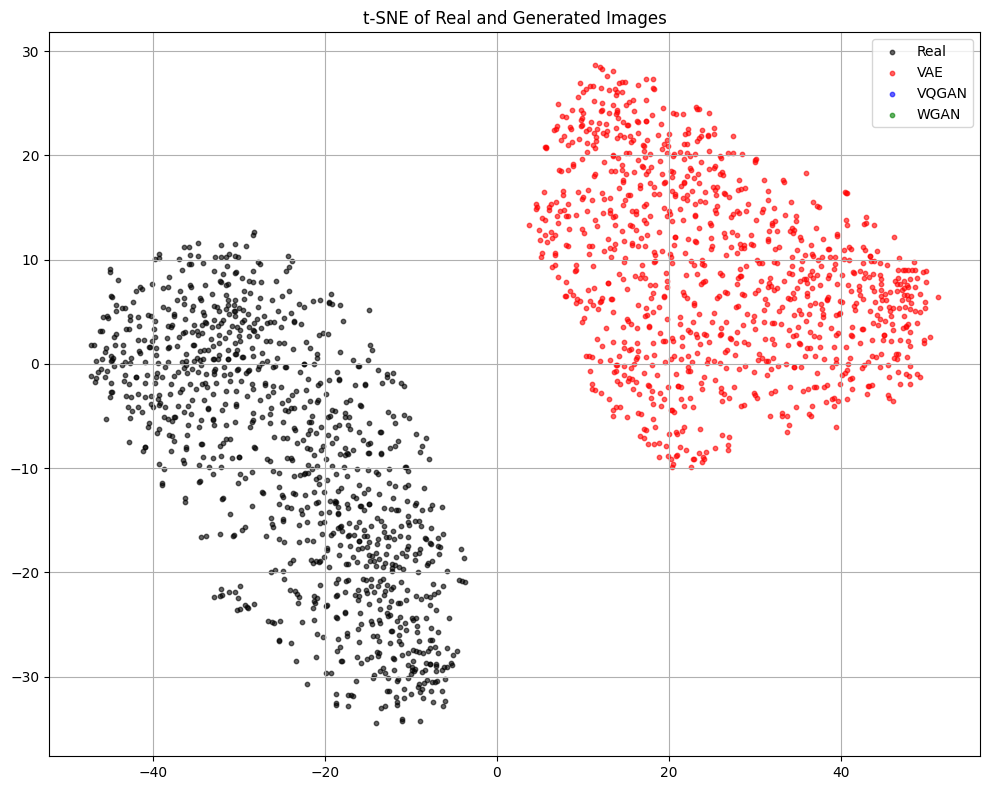

In [ ]:
# Feature Extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
model.fc = torch.nn.Identity()
model = model.to(device).eval()

# Feature extraction
features, labels = [], []
with torch.no_grad():
    for imgs, lbls in tqdm(loader, desc="Extracting features"):
        imgs = imgs.to(device)
        feats = model(imgs).cpu().numpy()
        features.append(feats)
        labels.extend(lbls.numpy())

features = np.vstack(features)
labels = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
colors = ['black', 'red', 'blue', 'green']
for i in range(4):
    idxs = labels == i
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], s=10, color=colors[i], label=label_map[i], alpha=0.6)

plt.legend()
plt.title("t-SNE of Real and Generated Images")
plt.grid(True)
plt.tight_layout()
plt.show()
